# COMP 551 — Assignment 4

Authors:
 - Bernier, Audréanne
 - Coull-Neveu, Ben
 - Trachsel-Bourbeau, Anjara

Imports

In [34]:
pip install unidecode gensim


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [49]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

from gensim.models import Word2Vec

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import unidecode
import string

import os
import multiprocessing
import logging # for logging training process
import time # to track training time
import pickle # to save models

## Defining Defaults

In [3]:
# define plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['legend.fancybox'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.autolayout'] = True
plt.rcParams['axes.autolimit_mode'] = 'data'  # default, ensures autoscale uses data
plt.rcParams["font.family"] = "serif"


# set default save directory and parameters
SAVEDIR = './figures/'
MODELDIR = './models/'
os.makedirs(SAVEDIR, exist_ok=True)
os.makedirs(MODELDIR, exist_ok=True)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# set log level
log = logging.getLogger()
log.setLevel(logging.INFO)  # set to logging.DEBUG for more detailed output
for handler in log.handlers[:]: # Remove existing handlers (important in Jupyter)
    log.removeHandler(handler)
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
formatter = logging.Formatter(
    fmt='%(asctime)s - %(message)s', 
    datefmt="%H:%M:%S" 
    )
handler.setFormatter(formatter)
log.addHandler(handler)

# Dataset

## Get data

X is input data that include text sequences

Y is target value 

YL1 is target value of level one (parent label)

YL2 is target value of level one (child label)

Labels in YL1 (scientific field):

- 0 - Computer Science
- 1 - Electrical Engineering
- 2 - Psychology
- 3 - Mechanical Engineering
- 4 - Civil Engineering
- 5 - Medical Science
- 6 - Biochemistry


In [42]:
def load_data(file_path, dtype=str)->np.ndarray:
    # read file 
    with open(file_path, "r") as f:
        lines = [line.strip() for line in f]  # list of all lines

    if dtype == int:
        return [int(x) for x in lines]  # make sure target lists are int type
    
    return np.array(lines)  # return array


def clean_text(text):
    text = text.lower()  # lowercase

    text = unicodedata.normalize("NFKD", text) # droping accents
    text = "".join(ch for ch in text if unicodedata.category(ch) != "Mn")

    punctuation = ",.;:!?\"'()[]{}<>@#$%^&*_+=/\\|`~•–—"  # list of punctuation to remove
    for p in punctuation:
        text = text.replace(p, " ")

    cleaned = []
    for ch in text:
        if ch.isalnum() or ch == '-' or ch == ' ': # keeping only alphanumeric, hyphens and spaces
            cleaned.append(ch)
        else:
            cleaned.append(" ")
    text = "".join(cleaned)

    while "  " in text:
        text = text.replace("  ", " ") # remove double spaces
    
    return text.strip()


class WOSDataset(Dataset):
    """
    Class to build a torch dataset from the WOS .txt files
    """

    def __init__(self, dataset_dir):
        self.Xraw = load_data(dataset_dir + 'X.txt')
        self.X = self.Xraw.copy()
        self.sentences = []
        self.Y = load_data(dataset_dir + 'Y.txt', dtype=int)
        self.YL1 = load_data(dataset_dir + 'YL1.txt', dtype=int)
        self.YL2 = load_data(dataset_dir + 'YL2.txt', dtype=int)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        raw = self.X[idx]
        cleaned = clean_text(raw)
        return cleaned, self.Y[idx], self.YL1[idx], self.YL2[idx]
    
    def clean_data(self):
        self.X = np.array([clean_text(x) for x in self.Xraw])
        
    def get_sentences(self):
        self.sentences = [text.split() for text in self.X]

In [44]:
# Loading WOS11967
dataset_dir = './datasets/WOS11967/'
WOS11967_dataset = WOSDataset(dataset_dir)

# train test split
TRAIN_RATIO = 0.8
num_train = int(len(WOS11967_dataset) * TRAIN_RATIO)
num_test = len(WOS11967_dataset) - num_train
train_dataset, test_dataset = random_split(WOS11967_dataset, [num_train, num_test])

# Get dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Note: X are strings so they currently get returned as a tuple when we get a batch
# eg. sample_X = (
#     "abstract1",
#     "abstract2",
#     "abstract3",
#     ...
# )


# Check data
num_instances = len(WOS11967_dataset)
print(f'Total number of samples: {len(WOS11967_dataset)}')
num_classes_YL1 = len(set(WOS11967_dataset.YL1))
print(f'Number of classes in YL1 (parent labels): {num_classes_YL1}')
num_classes_YL2 = len(set(WOS11967_dataset.YL2))
print(f'Number of classes in YL2 (child labels): {num_classes_YL2}')


# Check a sample (one batch)
sample_X, sample_Y, sample_YL1, sample_YL2 = next(iter(train_loader))
print(len(sample_X))  # (batch_size,)  THIS IS A TUPLE OF STRINGS
print(sample_Y.shape)  # (batch_size,)

Total number of samples: 11967
Number of classes in YL1 (parent labels): 7
Number of classes in YL2 (child labels): 5
32
torch.Size([32])


## Preprocess data

Things to clean (done):
- special charaters (accents, non-ASCII characters, etc)
- capitalization
- Remove tabs or non-single spaced spaces
- Remove poncutation, eg: , . ; : ( ) [ ]

Things to clean (to do):
- some abstracts end in citations, eg: (C) 2016 Elsevier B.V. All rights reserved.
- some abstracts contain weblinks, eg: the Menpo Project (http://www.menpo.org)
- some have institution of origin mentioned, eg: School of Aerospace, Mechanical and Manufacturing Engineering, RMIT University
- some use periods as part of chemical/physical formulas: eg, reduce PM2.5 effects 

In [ ]:
# Pre-procesing data for LSTM
WOS11967_dataset.clean_data()
WOS11967_dataset.get_sentences()
print(WOS11967_dataset.sentences[:5]) # first 5 sentences

[['the', 'aim', 'of', 'this', 'study', 'was', 'to', 'investigate', 'a', 'the', 'behavioral', 'cues', 'that', 'are', 'displayed', 'by', 'and', 'trait', 'judgments', 'formed', 'about', 'anxious', 'interviewees', 'and', 'b', 'why', 'anxious', 'interviewees', 'receive', 'lower', 'interview', 'performance', 'ratings', 'the', 'behavioral', 'expression', 'of', 'interview', 'anxiety', 'model', 'was', 'created', 'as', 'a', 'conceptual', 'framework', 'to', 'explore', 'these', 'relations', 'we', 'videotaped', 'and', 'transcribed', 'mock', 'job', 'interviews', 'obtained', 'ratings', 'of', 'interview', 'anxiety', 'and', 'interview', 'performance', 'and', 'trained', 'raters', 'to', 'assess', 'several', 'verbal', 'and', 'nonverbal', 'cues', 'and', 'trait', 'judgments', 'the', 'results', 'indicated', 'that', 'few', 'behavioral', 'cues', 'but', 'several', 'traits', 'were', 'related', 'to', 'interviewee', 'and', 'interviewer', 'ratings', 'of', 'interview', 'anxiety', 'two', 'factors', 'emerged', 'from',

In [ ]:
print('Number of CPU threads available:', multiprocessing.cpu_count())

Number of CPU threads available: 16


In [65]:
# encoding model
w2v_model = Word2Vec(
    sentences = WOS11967_dataset.sentences,
    vector_size = 100,
    window = 5,
    min_count = 1,
    workers = 8,
    epochs = 15,
    
)

21:32:24 - collecting all words and their counts
21:32:24 - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
21:32:24 - PROGRESS: at sentence #10000, processed 1972401 words, keeping 69777 word types
21:32:24 - collected 77423 word types from a corpus of 2362957 raw words and 11967 sentences
21:32:24 - Creating a fresh vocabulary
21:32:25 - Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 77423 unique words (100.00% of original 77423, drops 0)', 'datetime': '2025-11-30T21:32:25.031760', 'gensim': '4.4.0', 'python': '3.11.5 (v3.11.5:cce6ba91b3, Aug 24 2023, 10:50:31) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.4.1-x86_64-i386-64bit', 'event': 'prepare_vocab'}
21:32:25 - Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 2362957 word corpus (100.00% of original 2362957, drops 0)', 'datetime': '2025-11-30T21:32:25.032544', 'gensim': '4.4.0', 'python': '3.11.5 (v3.11.5:cce6ba91b3, Aug 24 2023, 10:50:31) [Clang 13.0.0 (clang-1300.0

In [7]:
# Pre-processing data for BERT

## Compute Statistics

In [8]:
def get_stats(data_list, parent_labels=np.arange(7), child_labels=np.arange(5)):
    """
    Compute statistics for a given dataset list.
    Returns a dictionary with total samples and distributions of YL1 and their respective YL2 labels.
    """
    total_samples = len(data_list)
    counts = {
        yl1: {yl2: 0 for yl2 in child_labels} for yl1 in parent_labels
    }

    for _, _, yl1, yl2 in data_list:
        if yl1 not in counts:
            counts[yl1] = {}
        counts[yl1][yl2] = counts[yl1].get(yl2, 0) + 1

    stats = {
        'total_samples': total_samples,
        'yl_distribution': counts,
    }
    return stats


def plot_stats(data_stats, ax, parent_labels=[], child_labels=[], width_parent=0.8):
    """
    Plot statistics from get_stats function.
    """

    dists = data_stats['yl_distribution']
    num_child = len(child_labels)  # number of child labels
    width = width_parent/num_child  # with of each child bar

    for i, parent in enumerate(parent_labels):
        counts = dists[parent].values()
        x = np.linspace(i-2*width, i+2*width, 5) 
        ax.bar(x, counts, width=width, color="#82a872", edgecolor='k')


In [9]:
# Get lists of train and test data
train_list = [train_dataset[i] for i in range(len(train_dataset))]
test_list  = [test_dataset[i] for i in range(len(test_dataset))]

# Get distibutions for each label
train_stats = get_stats(train_list)
test_stats = get_stats(test_list)

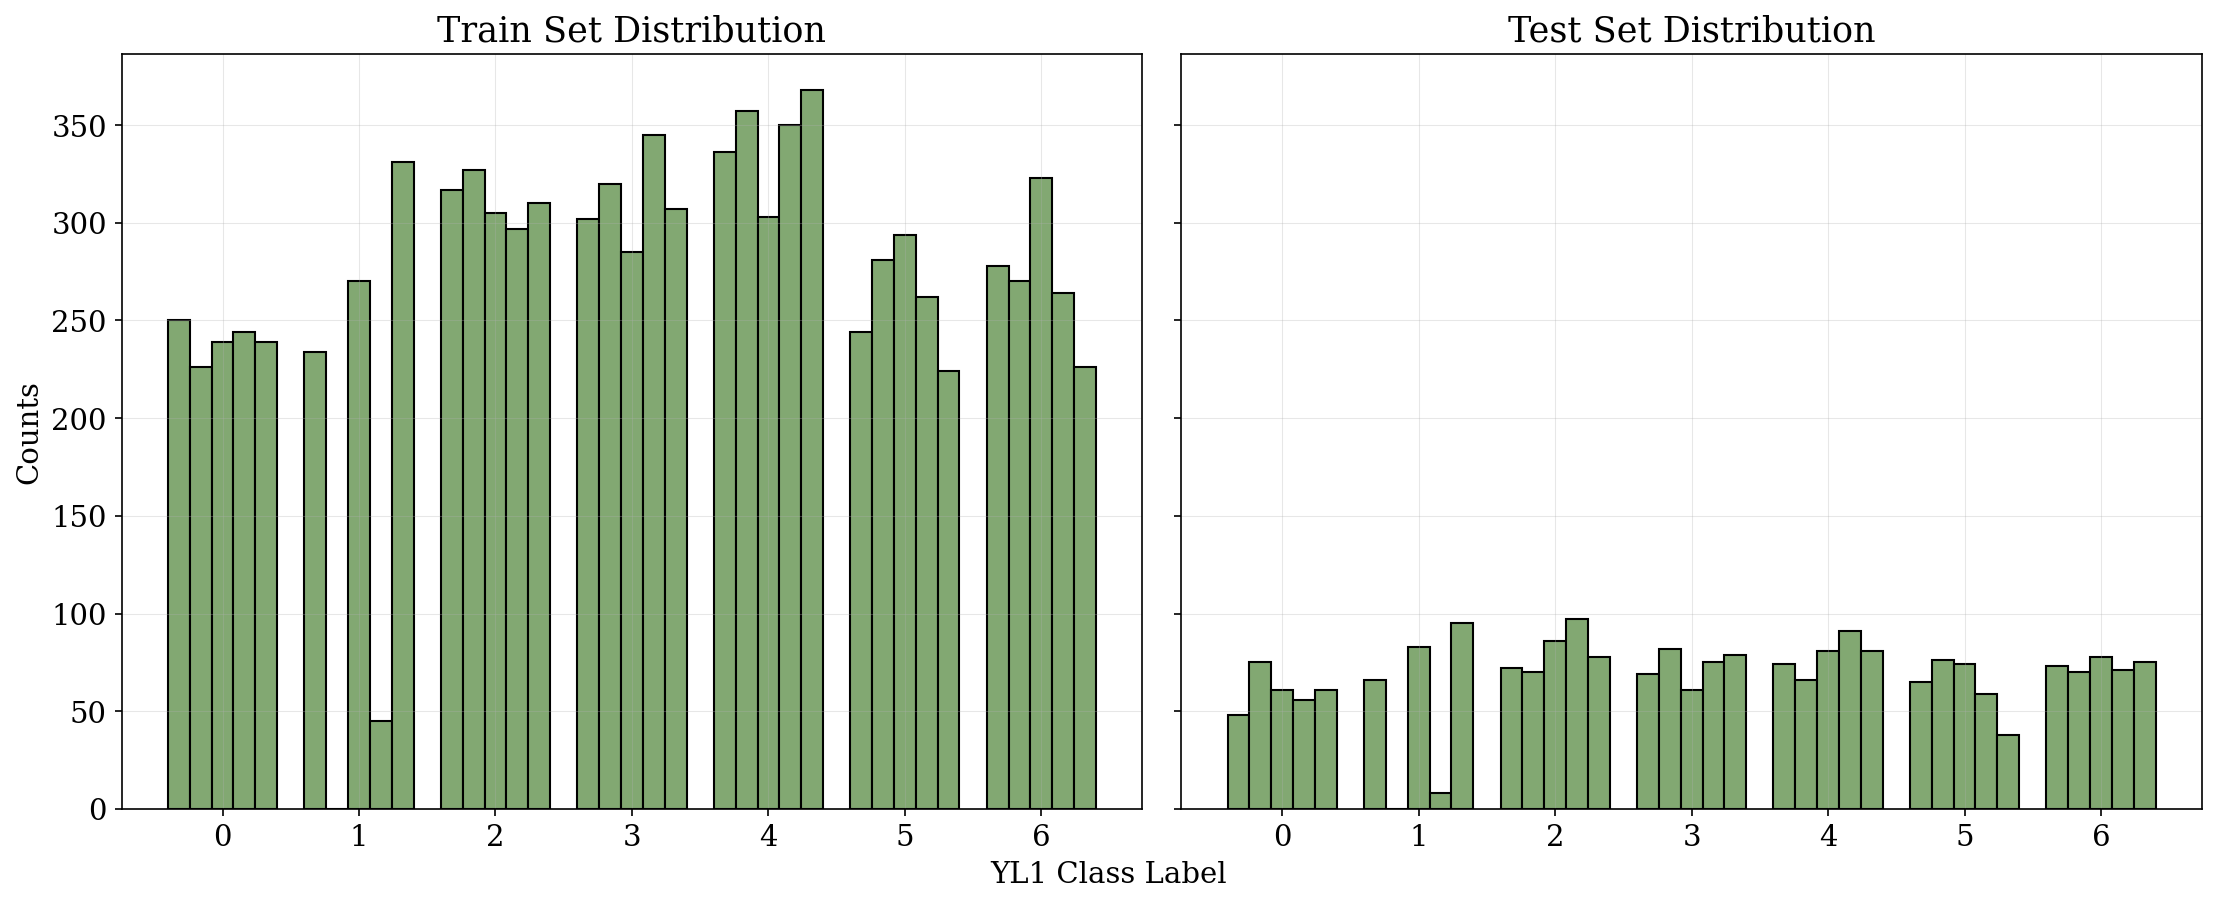

In [10]:
# Get all possible labels
parent_labels = np.arange(len(set(WOS11967_dataset.YL1)))
child_labels = np.arange(len(set(WOS11967_dataset.YL2)))

# Plot stats
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)
plot_stats(train_stats, ax1, parent_labels=parent_labels, child_labels=child_labels)
plot_stats(test_stats, ax2, parent_labels=parent_labels, child_labels=child_labels)

# Labels
fig.text(0.5, 0, "YL1 Class Label", ha='center')
ax1.set_ylabel("Counts")

# Titles
ax1.set_title('Train Set Distribution')
ax2.set_title('Test Set Distribution')

plt.tight_layout()
plt.savefig(SAVEDIR + 'YL1_YL2_distribution.png')
plt.show()

# Implement LSTM class

- can use pytorch.nn.Module
- For the LSTM model, you must design the data pre-processing pipeline that turns the unstructured text data into
numerical features. You are free to choose your encoding method, including pre-trained methods like word2vec;
however, there should be some justification for your choice in your report.

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device='cuda'):
        super().__init__()
        
        device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.to(device)
        self.device = device
        
        # based heavily on pytorch implementation (but changed notation)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # training records (to add...)
        self.training_time = []
        self.training_loss = []
        self.validation_loss = []
        
        
        # Input gate
        self.W_xi = nn.Linear(input_size, hidden_size, bias=True) # input
        self.W_hi = nn.Linear(hidden_size, hidden_size, bias=True) # hidden
        
        # Forget gate
        self.W_xf = nn.Linear(input_size, hidden_size, bias=True) # input
        self.W_hf = nn.Linear(hidden_size, hidden_size, bias=True) # hidden
        
        # Candidate state
        self.W_xc = nn.Linear(input_size, hidden_size, bias=True) # input
        self.W_hc = nn.Linear(hidden_size, hidden_size, bias=True) # hidden

        # Output gate
        self.W_xo = nn.Linear(input_size, hidden_size, bias=True) # input
        self.W_ho = nn.Linear(hidden_size, hidden_size, bias=True) # hidden
        
        # Output layer
        self.W_hy = nn.Linear(hidden_size, output_size, bias=True)
        
        
    def forward(self, x, hidden=None): 
        """ 
        Args:
            x: (batch_size, seq_len, input_size)
            hidden: tuple of (h, c) each (batch_size, hidden_size)
        """
        batch_size, seq_len, _ = x.size()
        
        if hidden is None:
            h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
            cs_t = torch.zeros(batch_size, self.hidden_size, device=x.device) # cell state
        else:
            h_t, cs_t = hidden
            
        for t in range(seq_len):
            x_t = x[:, t, :]
        
            i_t = torch.sigmoid(self.W_xi(x_t) + self.W_hi(h_t))
            f_t = torch.sigmoid(self.W_xf(x_t) + self.W_hf(h_t))
            c_t = torch.tanh(self.W_xc(x_t) + self.W_hc(h_t))
            o_t = torch.sigmoid(self.W_xo(x_t) + self.W_ho(h_t))
        
            cs_t = f_t * cs_t + i_t * c_t # update cell state
            h_t = o_t * torch.tanh(cs_t) # update hidden state
             
        y = self.W_hy(h_t) # bias included in Linear layer
        return y, (h_t, cs_t)
    
    
    def fit(self, dataset, epochs=10, lr=1e-3, batch_size=32, shuffle=True, optimizer='Adam', val_train_split=0, store_records=False):
        """
        Can chose between optimizers: Adam, RMSprop, Adagrad
        """        
        log.info(" == LSTM Training Initialization ==")
        if val_train_split > 0:
            val_size = int(len(dataset) * val_train_split)
            train_size = len(dataset) - val_size
            train_set, val_set = random_split(dataset, [train_size, val_size])
            val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
            dataset = train_set  # for training loader
            log.info(f"Splitting dataset into {100*(1-val_train_split):.1f}% train and {100*val_train_split:.1f}% validation")
        else:
            val_loader = None
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        log.info(f"Training on {len(train_loader.dataset)} samples in {len(train_loader)} batches of size {batch_size}")
        
        # getting optimizer
        if  optimizer == 'Adam':
            opt = torch.optim.Adam(self.parameters(), lr=lr)
        elif optimizer == 'RMSprop':
            opt = torch.optim.RMSprop(self.parameters(), lr=lr)
        elif optimizer == 'Adagrad':
            opt = torch.optim.Adagrad(self.parameters(), lr=lr)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer}")
        
        log.info(f"Using {optimizer} optimizer with learning rate {lr}")
        
        # defining loss function to be cross entropy
        loss_fn = nn.CrossEntropyLoss()

        # training loop!
        log.info(" == Training LSTM Model ==")
        for epoch in range(epochs):
            t = time.time()
            total_loss = 0
            for X, Y in train_loader:
                X, Y = X.to(self.device), Y.to(self.device)

                opt.zero_grad()
                logits, _ = self.forward(X)
                loss = loss_fn(logits, Y)
                loss.backward()
                opt.step()

                total_loss += loss.item()
                
                if val_loader is not None:
                    val_loss = 0
                    for val_X, val_Y in val_loader:
                        val_X, val_Y = val_X.to(self.device), val_Y.to(self.device)
                        val_logits, _ = self.forward(val_X)
                        v_loss = loss_fn(val_logits, val_Y)
                        val_loss += v_loss.item()
                    avg_val_loss = val_loss / len(val_loader)
                    
            avg_loss = total_loss / len(train_loader)
            t_epoch = time.time() - t
            time_to_completion = t_epoch * (epochs - epoch - 1) / 60
            if store_records:
                self.training_time.append(t_epoch)
                self.training_loss.append(avg_loss)
                if val_loader is not None:
                    self.validation_loss.append(avg_val_loss)

            if log.getEffectiveLevel() <= logging.INFO: # print only if log level is INFO. Doing this to avoid issues with logging output
                if val_loader is not None:
                    print(f"Epoch {epoch+1}/{epochs}, Train Loss = {avg_loss:.4f}, Val Loss = {avg_val_loss:.4f} -- Time: {t_epoch:.2f}s == ~{time_to_completion:.2f}min remaining {' '*10}", end='\r') 
                else:
                    print(f"Epoch {epoch+1}/{epochs}, Train Loss = {avg_loss:.4f} -- Time: {t_epoch:.2f}s == ~{time_to_completion:.2f}min remaining {' '*10}", end='\r') 
    
    
    @torch.no_grad() # disable gradient calculation for inference
    def predict(self, X,):
        X = X.to(self.device)
        logits, _ = self.forward(X)
        return torch.argmax(logits, dim=1).cpu()

    
    def evaluate_acc(self, Y, Yhat):
        return np.mean(Y == Yhat)
    
    def plot_training_loss(self):
        plt.plot(self.training_loss)
        plt.xlabel('Epoch')
        plt.ylabel('Training Loss')
        plt.title('Training Loss over Epochs')
        plt.show()

# BERT model

- For BERT, you can use the transformers package to tokenize the input text and convert the tokens into numeri-
cal features https://pytorch.org/hub/huggingface_pytorch-transformers/
- 

# Experiments

## some experiment etc